In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
%config inlineBackend.figure_format='svg'
import matplotlib.pyplot as pt
pt.style.use('ggplot')
import folium
from ipywidgets import interactive
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import re
from tqdm import tqdm
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
      '#46f0f0', '3f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
      '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
      '#000075', '#808080'] * 10

In [2]:
df = pd.read_csv('Kebakaran_Jakbar_2020.csv',
                 delimiter = ','
                )

In [3]:
df.duplicated(subset = ['Lat', 'Lon']).values.any()

True

In [4]:
df.isna().values.any()

False


In [5]:
print(f'Before Drop, Nulls and Duplicates:\tdf.shape = {df.shape}')

df.dropna(inplace = True)
df.drop_duplicates(subset = ['Lat', 'Lon'],
                   keep = 'first',
                   inplace = True
                  )

print(f'After Drop, Nulls and Duplicates:\tdf.shape = {df.shape}')

Before Drop, Nulls and Duplicates:	df.shape = (314, 9)
After Drop, Nulls and Duplicates:	df.shape = (286, 9)


In [6]:
df

alamat_kejadian         kelurahan  \
0     Jl. Panjang Green Garden, Blok. I, No. 18      Kedoya Utara   
1                    Jl. Prepedan Dalam, No. 45             Kamal   
2    Jl. Daan Mogot, No. 147 (Pom Bensin Shell)         Duri Kepa   
3            Jl. Mangga Besar IX, Gg. I, No. 12            Tangki   
4                       Jl. Al Ma'rifah, No. 72        Rawa Buaya   
..                                          ...               ...   
308                        Jl. Madrasah 1 Gg WW    Sukabumi Utara   
309                        Jl. Krendang Selatan          Krendang   
311                                Jl.Badilah 1            Tangki   
312  Jl.Taman Palem Mutiara Blok B7 No..56 - 57  Cengkareng Timur   
313           Jl. Taman Palm Mutiara Blok C8/01  Cengkareng Timur   

       kecamatan                                            Address  \
0    Kebun Jeruk  Jl. Panjang Green Garden, Blok. I, No. 18, Ked...   
1      Kalideres       Jl. Prepedan Dalam, No. 45, Kamal, Kalideres   
2    Kebun Jeruk  Jl. Daan Mogot, No. 147 (Pom Bensin Shell), Du...   
3      Tamansari  Jl. Mangga Besar IX, Gg. I, No. 12, Tangki, Ta...   
4     Cengkareng    Jl. Al Ma'rifah, No. 72, Rawa Buaya, Cengkareng   
..           ...                                                ...   
308  Kebun Jeruk  Jl. Madrasah 1 Gg WW, Sukabumi Utara, Kebun Jeruk   
309      Tambora            Jl. Krendang Selatan, Krendang, Tambora   
311    Tamansari                    Jl.Badilah 1, Tangki, Tamansari   
312   Cengkareng  Jl.Taman Palem Mutiara Blok B7 No..56 - 57, Ce...   
313   Cengkareng  Jl. Taman Palm Mutiara Blok C8/01, Cengkareng ...   

                                              Location  \
0    Perumahan Green Garden Blok i1 no: 18, RT.4/RW...   
1    7, Jl. Prepedan Dalam No.10, RT.10/RW.7, Kamal...   
2    4, Jl. Daan Mogot No.147, RT.4/RW.5, Duri Kepa...   
3    12, Jl. Mangga Besar IX No.28b, RT.12/RW.1, Ta...   
4    Jl. Al-Ma'rifah No.72, RT.1/RW.12, Rw. Buaya, ...   
..                                                 ...   
308  Jl. WW, Sukabumi Utara, Kec. Kb. Jeruk, Kota J...   
309  Jl. Krendang Sel., Krendang, Kec. Tambora, Kot...   
311  Jl. Badila I, Tangki, Kec. Taman Sari, Kota Ja...   
312  No..56 - 57, Jl. Taman Palem Mutiara Blok B7 N...   
313  Jl. Taman Palem Mutiara, Cengkareng Tim., Keca...   

                                      Point       Lat         Lon  Alt  
0            (-6.1659082, 106.7621509, 0.0) -6.165908  106.762151    0  
1    (-6.111170400000001, 106.7025281, 0.0) -6.111170  106.702528    0  
2            (-6.1635089, 106.7743823, 0.0) -6.163509  106.774382    0  
3            (-6.1465418, 106.8239602, 0.0) -6.146542  106.823960    0  
4            (-6.1637588, 106.7435497, 0.0) -6.163759  106.743550    0  
..                                      ...       ...         ...  ...  
308          (-6.2131985, 106.7768966, 0.0) -6.213198  106.776897    0  
309          (-6.1527306, 106.8029195, 0.0) -6.152731  106.802920    0  
311          (-6.1451537, 106.8227525, 0.0) -6.145154  106.822752    0  
312            (-6.142597, 106.731084, 0.0) -6.142597  106.731084    0  
313          (-6.1402323, 106.7327866, 0.0) -6.140232  106.732787    0  

[286 rows x 9 columns]

In [7]:
type('Lat')

str

In [8]:
F = np.array(df[['Lat', 'Lon']],
             dtype  = 'float64'
            )

F

array([[ -6.1659082, 106.7621509],
       [ -6.1111704, 106.7025281],
       [ -6.1635089, 106.7743823],
       [ -6.1465418, 106.8239602],
       [ -6.1637588, 106.7435497],
       [ -6.1679798, 106.7625571],
       [ -6.1844959, 106.7358085],
       [ -6.1642524, 106.7299479],
       [ -6.2073341, 106.7412936],
       [ -6.1476121, 106.7448883],
       [ -6.1507927, 106.7023772],
       [ -6.154996 , 106.8210121],
       [ -6.1885209, 106.7923889],
       [ -6.1909604, 106.7882376],
       [ -6.1590306, 106.7683187],
       [ -6.1754263, 106.7867273],
       [ -6.1531019, 106.7311322],
       [ -6.1544036, 106.8215967],
       [ -6.135875 , 106.6905899],
       [ -6.1887087, 106.7556308],
       [ -6.158692 , 106.82034  ],
       [ -6.15509  , 106.820954 ],
       [ -6.1466374, 106.8238469],
       [ -6.1574003, 106.8174234],
       [ -6.1494088, 106.729649 ],
       [ -6.1416396, 106.807986 ],
       [ -6.1784958, 106.7440861],
       [ -6.1519744, 106.7759074],
       [ -6.2032007,

In [9]:
type(F)

numpy.ndarray

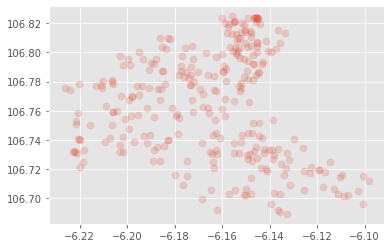

In [10]:
pt.scatter(F[:,0], F[:,1],
           alpha = 0.2,
           s = 50
          )

In [11]:
m = folium.Map(
    location = [df.Lat.mean(), df.Lon.mean()],
    zoom_starts = 12,
    tiles = 'CartoDB dark_matter'
)

for _, row in df.iterrows():
    folium.CircleMarker(
        location = [row.Lat, row.Lon],
        radius = 5,
        popup = re.sub(r'[^a-zA-Z ]+', '', row.Address),
        color = '#1787FE',
        fill = True,
        fill_color = '#1787FE'
    ).add_to(m)
    
m

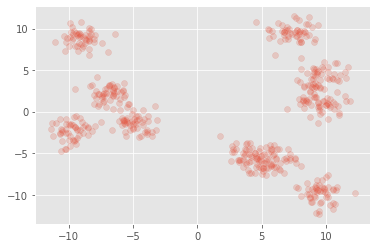

In [12]:
F_blobs, _ = make_blobs(
    n_samples = 500,
    centers = 10,
    n_features = 2,
    cluster_std = 1,
    random_state = 4
)

pt.scatter(F_blobs[:,0], F_blobs[:,1],
           alpha = 0.2
          )

In [13]:
F_blobs

array([[ -9.34859697,  -2.21328685],
       [  9.56860938,   4.50869016],
       [  9.42186055,   0.70412081],
       [ -6.21119176,   2.46765653],
       [ -4.22637758,  -1.55977372],
       [  5.47835905,  -6.80268473],
       [ -4.59958988,  -0.49006848],
       [  9.11880811, -10.29845114],
       [  8.80240761, -10.83700883],
       [  2.96366327,  -3.76295852],
       [  7.16762049,   9.45112476],
       [  8.54973834,  -8.58287776],
       [-10.17689747,  -2.55805499],
       [ -7.27112226,   1.93204707],
       [  4.47723223,  -4.95526112],
       [  9.38919979,   1.13329119],
       [  5.70199113,  -4.44043769],
       [  9.05081742,   4.75422609],
       [ -9.2471094 ,   7.24418644],
       [ -8.41860521,   6.82814942],
       [  5.24455521,  -6.22439508],
       [  8.7337095 ,   2.49162431],
       [  7.52181201,  11.4832343 ],
       [  8.03248152,  -6.58015282],
       [ -5.72471494,  -0.94765143],
       [ -4.71615551,  -1.91811419],
       [ -5.19618105,  -1.65844505],
 

In [14]:
type(F_blobs)

numpy.ndarray

In [15]:
km = KMeans(n_clusters = 3).fit(F_blobs)

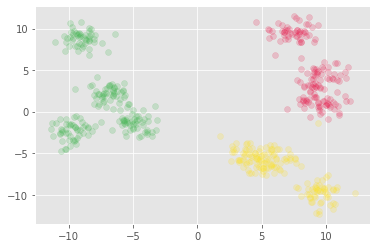

In [18]:
class_predictions = km.predict(F_blobs)

unique_clusters = np.unique(class_predictions)

for unique_cluster in unique_clusters:
    F = F_blobs[class_predictions == unique_cluster]
    pt.scatter(F[:,0], F[:,1],
               alpha = 0.2,
               c = cols[unique_cluster]
              )

In [114]:
silhouette_score(F_blobs, class_predictions)

0.6385465948907103

In [19]:
F_blobs, _ = make_blobs(
    n_samples = 250,
    centers = 50,
    n_features = 2,
    cluster_std = 1,
    random_state = 4
)

In [20]:
#silhouette_score(F_blobs, class_predictions)

In [21]:
data = defaultdict(dict)

for x in range(1,21):
    km = KMeans(
        n_clusters = 3,
        random_state = 17,
        max_iter = x,
        n_init = 1
    ).fit(F_blobs)
    
    data[x]['class_predictions'] = km.predict(F_blobs)
    data[x]['centroids'] = km.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [22]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']
    
    for unique_class in unique_classes:
        pt.scatter(F_blobs[class_predictions == unique_class][:,0],
                   F_blobs[class_predictions == unique_class][:,1],
                   alpha = 0.3,
                   c = cols[unique_class]
                  )
        
    pt.scatter(centroids[:,0], centroids[:,1],
               s = 200,
               c = '#000000',
               marker = '*'
              )
    
    pt.ylim([-15,15]); pt.xlim([-15,15])
    pt.title('K-Means Clustering')

interactive_plot = interactive(f, x = (1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'

interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [119]:
F = np.array(df[['Lat', 'Lon']],
             dtype='float64'
            )

k = 3
km = KMeans(n_clusters = k,
            random_state = 17
           ).fit(F)

class_predictions = km.predict(F)

df[f'Cluster_km{k}'] = class_predictions

df.head()

alamat_kejadian     kelurahan    kecamatan  \
0   Jl. Panjang Green Garden, Blok. I, No. 18  Kedoya Utara  Kebun Jeruk   
1                  Jl. Prepedan Dalam, No. 45         Kamal    Kalideres   
2  Jl. Daan Mogot, No. 147 (Pom Bensin Shell)     Duri Kepa  Kebun Jeruk   
3          Jl. Mangga Besar IX, Gg. I, No. 12        Tangki    Tamansari   
4                     Jl. Al Ma'rifah, No. 72    Rawa Buaya   Cengkareng   

                                             Address  \
0  Jl. Panjang Green Garden, Blok. I, No. 18, Ked...   
1       Jl. Prepedan Dalam, No. 45, Kamal, Kalideres   
2  Jl. Daan Mogot, No. 147 (Pom Bensin Shell), Du...   
3  Jl. Mangga Besar IX, Gg. I, No. 12, Tangki, Ta...   
4    Jl. Al Ma'rifah, No. 72, Rawa Buaya, Cengkareng   

                                            Location  \
0  Perumahan Green Garden Blok i1 no: 18, RT.4/RW...   
1  7, Jl. Prepedan Dalam No.10, RT.10/RW.7, Kamal...   
2  4, Jl. Daan Mogot No.147, RT.4/RW.5, Duri Kepa...   
3  12, Jl. Mangga Besar IX No.28b, RT.12/RW.1, Ta...   
4  Jl. Al-Ma'rifah No.72, RT.1/RW.12, Rw. Buaya, ...   

                                    Point       Lat         Lon  Alt  \
0          (-6.1659082, 106.7621509, 0.0) -6.165908  106.762151    0   
1  (-6.111170400000001, 106.7025281, 0.0) -6.111170  106.702528    0   
2          (-6.1635089, 106.7743823, 0.0) -6.163509  106.774382    0   
3          (-6.1465418, 106.8239602, 0.0) -6.146542  106.823960    0   
4          (-6.1637588, 106.7435497, 0.0) -6.163759  106.743550    0   

   Cluster_km3  
0            2  
1            1  
2            0  
3            0  
4            1

In [120]:
silhouette_score(F, class_predictions)

0.5043670449743513

In [121]:
type(silhouette_score)

function

In [122]:
clst_center = km.cluster_centers_
clst_center

array([[ -6.15811931, 106.79917088],
       [ -6.14129547, 106.72169472],
       [ -6.19925678, 106.75667963]])

In [123]:
pd.DataFrame(clst_center).to_csv('C:/Users/kevin/Documents/clst_center.csv', header = None, index = None)

In [124]:
# upload dulu ke jupyter baru read.csv
# tambahin header "La" ama "Lo" di file csv nya
cc = pd.read_csv('clst_center.csv')
cc

La          Lo
0 -6.158119  106.799171
1 -6.141295  106.721695
2 -6.199257  106.756680

In [125]:
def create_map(df, cluster_column):
    m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )
    
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location = [row['Lat'], row['Lon']],
            radius = 5,
            popup = folium.Popup(row[cluster_column]),
            color = cluster_colour,
            fill = True,
            fill_color = cluster_colour
            ).add_to(m)
        
    return(m)

m = create_map(df, 'Cluster_km3')

m

In [126]:
def create_map(df, cluster_column):
    m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )
    
    c = folium.Choropleth(geo_data = r"id-jk-jakbar.geojson", 
                          name = 'Choropleth', 
                          highlight = True,
                          line_color='black',
                          line_weight = 2,
                          fill_color = 'lightgray',
                          opacity = 0.5
                         ).add_to(m)

    c.geojson.add_child(folium.features.GeoJsonTooltip(['name'], labels = False)
                       )

    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location = [row['Lat'], row['Lon']],
            radius = 5,
            popup = folium.Popup(row[cluster_column]),
            color = cluster_colour,
            fill = True,
            fill_color = cluster_colour
            ).add_to(m)
        
    return(m)

m = create_map(df, 'Cluster_km3')

m

In [127]:
def create_map(df, cluster_column):
    m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )
    
    folium.Marker(location = [-6.158119307563025, 106.79917087731093], 
                  popup = "<b>Centroid 1</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)
    
    folium.Marker(location = [-6.141295466666667, 106.72169471954022],
                  popup = "<b>Centroid 2</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)
        
    folium.Marker(location = [-6.1992567775, 106.75667962625],
                  popup = "<b>Centroid 3</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)
    
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location = [row['Lat'], row['Lon']],
            radius = 5,
            popup = folium.Popup(row[cluster_column]),
            color = cluster_colour,
            fill = True,
            fill_color = cluster_colour
            ).add_to(m)
        
    return(m)

m = create_map(df, 'Cluster_km3')

m

In [128]:
def create_map(df, cluster_column):
    m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )
    
    c = folium.Choropleth(geo_data = r"id-jk-jakbar.geojson", 
                          name = 'Choropleth', 
                          highlight = True,
                          line_color='white',
                          line_weight = 2,
                          fill_color = 'lightgray',
                          opacity = 0.5
                         ).add_to(m)

    c.geojson.add_child(folium.features.GeoJsonTooltip(['name'],
                                                       labels = False)
                       )

    folium.Marker(location = [-6.158119307563025, 106.79917087731093], 
                  popup = "<b>Centroid 1</b>",
                  icon = folium.Icon(color = 'blue')    
                 ).add_to(m)
    
    folium.Marker(location = [-6.141295466666667, 106.72169471954022], 
                  popup = "<b>Centroid 2</b>",
                  icon = folium.Icon(color = 'blue')    
                 ).add_to(m)
        
    folium.Marker(location = [-6.1992567775, 106.75667962625], 
                  popup = "<b>Centroid 3</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)
    
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location = [row['Lat'], row['Lon']],
            radius = 5,
            popup = folium.Popup(row[cluster_column]),
            color = cluster_colour,
            fill = True,
            fill_color = cluster_colour
            ).add_to(m)
        
    return(m)

m = create_map(df, 'Cluster_km3')

m

In [79]:
pp = pd.read_csv('Pos_Damkar_Jakbar.csv')

In [80]:
def create_map(df, cluster_column):
    m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )
    
    c = folium.Choropleth(geo_data = r"id-jk-jakbar.geojson", 
                          name = 'Choropleth', 
                          highlight = True,
                          line_color='white',
                          line_weight = 2,
                          fill_color = 'lightgray',
                          opacity = 0.5
                         ).add_to(m)

    c.geojson.add_child(folium.features.GeoJsonTooltip(['name'], labels = False)
                       )
    
    for _, row in pp.iterrows():
        folium.Marker(
        location = [row.Latitude, row.Longitude],
        radius = 5,
        icon = folium.Icon(color = 'red',  icon = 'home'),
        tooltip = row.Nama_Pos_Damkar
    ).add_to(m)
    
    folium.Marker(location = [-6.158119307563025, 106.79917087731093], 
                  popup = "<b>Centroid 1</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)
    
    folium.Marker(location = [-6.141295466666667, 106.72169471954022], 
                  popup = "<b>Centroid 2</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)
        
    folium.Marker(location = [-6.1992567775, 106.75667962625],
                  popup = "<b>Centroid 3</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)
    
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location = [row['Lat'], row['Lon']],
            radius = 5,
            popup = folium.Popup(row[cluster_column]),
            color = cluster_colour,
            fill = True,
            fill_color = cluster_colour
            ).add_to(m)
        
    return(m)

m = create_map(df, 'Cluster_km3')

m

In [137]:
best_s, best_k = -1, 0

for k in tqdm(range(2, 200)):
    km = KMeans(n_clusters = k,
                random_state = 1
               ).fit(F)
    
    class_predictions = km.predict(F)
    
    slht = silhouette_score(F, class_predictions)
    if slht > best_s:
        best_k = k
        best_s = slht
        
print(f'K: {best_k}')
print(f'Silhouette Score: {best_s}')

100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [01:37<00:00,  2.03it/s]

K: 3
Silhouette Score: 0.5043670449743513


In [138]:
best_e = range(1, 10)
ssd = []
for k in best_e:
    km = KMeans(n_clusters = k)
    km.fit(F)
    ssd.append(km.inertia_)
    
ssd

[0.611945075065099,
 0.310084103794629,
 0.15643920071329592,
 0.12032401066480294,
 0.09489678841189074,
 0.07562463477961857,
 0.06558942456707412,
 0.0558306861359401,
 0.048576677007284845]

In [139]:
type(ssd)

list

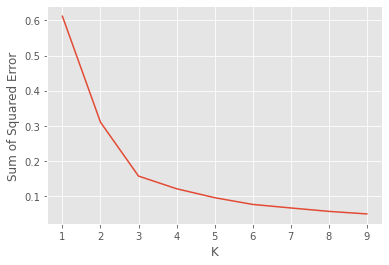

In [140]:
pt.xlabel('K')
pt.ylabel('Sum of Squared Error')
pt.plot(best_e, ssd)

In [90]:
pp = pd.read_csv('Pos_Damkar_Jakbar.csv')
pp

Wilayah               Nama_Sektor  \
0   Sudin Damkar-PB Kota Administrasi Jakarta Barat  Sektor Grogol Petamburan   
1   Sudin Damkar-PB Kota Administrasi Jakarta Barat  Sektor Grogol Petamburan   
2   Sudin Damkar-PB Kota Administrasi Jakarta Barat  Sektor Grogol Petamburan   
3   Sudin Damkar-PB Kota Administrasi Jakarta Barat           Sektor Palmerah   
4   Sudin Damkar-PB Kota Administrasi Jakarta Barat           Sektor Palmerah   
5   Sudin Damkar-PB Kota Administrasi Jakarta Barat            Sektor Tambora   
6   Sudin Damkar-PB Kota Administrasi Jakarta Barat            Sektor Tambora   
7   Sudin Damkar-PB Kota Administrasi Jakarta Barat            Sektor Tambora   
8   Sudin Damkar-PB Kota Administrasi Jakarta Barat            Sektor Tambora   
9   Sudin Damkar-PB Kota Administrasi Jakarta Barat          Sektor Tamansari   
10  Sudin Damkar-PB Kota Administrasi Jakarta Barat          Sektor Tamansari   
11  Sudin Damkar-PB Kota Administrasi Jakarta Barat   Sektor Kebon Jeruk Baru   
12  Sudin Damkar-PB Kota Administrasi Jakarta Barat        Sektor Kebun Jeruk   
13  Sudin Damkar-PB Kota Administrasi Jakarta Barat        Sektor Kebun Jeruk   
14  Sudin Damkar-PB Kota Administrasi Jakarta Barat          Sektor Kembangan   
15  Sudin Damkar-PB Kota Administrasi Jakarta Barat          Sektor Kembangan   
16  Sudin Damkar-PB Kota Administrasi Jakarta Barat          Sektor Kembangan   
17  Sudin Damkar-PB Kota Administrasi Jakarta Barat         Sektor Cengkareng   
18  Sudin Damkar-PB Kota Administrasi Jakarta Barat         Sektor Cengkareng   
19  Sudin Damkar-PB Kota Administrasi Jakarta Barat         Sektor Cengkareng   
20  Sudin Damkar-PB Kota Administrasi Jakarta Barat         Sektor Cengkareng   
21  Sudin Damkar-PB Kota Administrasi Jakarta Barat         Sektor Cengkareng   
22  Sudin Damkar-PB Kota Administrasi Jakarta Barat          Sektor Kalideres   
23  Sudin Damkar-PB Kota Administrasi Jakarta Barat          Sektor Kalideres   
24  Sudin Damkar-PB Kota Administrasi Jakarta Barat          Sektor Kalideres   

                          Nama_Bangunan  \
0        Kantor Sudin Pemadam Kebakaran   
1       Kantor Sektor Grogol Petamburan   
2                  Pos Pemadam Duta Mas   
3                 Pos  Balakar Palmerah   
4                   Pos Damkar Jatipulo   
5                 Kantor Sektor Tambora   
6                             Pos Angke   
7                          Pos Krendang   
8   Pos Pemadam Kebakaran Jembatan Besi   
9              Kantor Sektor Taman Sari   
10                         Pos Lokasari   
11         Suku Dinas Pemadam Kebakaran   
12            Kantor Sektor Kebon Jeruk   
13       Pos Pemadam Siloam Kebon Jeruk   
14             Kantor Sektor Kembangan    
15                  Pos Puri Kembangan    
16                            Pos Joglo   
17             Kantor Sektor Cengkareng   
18                         Sektor Palem   
19                     Pos Duri Kosambi   
20                       Pos Rawa Buaya   
21                          Pos Samsat    
22                        Pos Kalideres   
23               Pos Pemadam Pegadungan   
24                        Kantor Sektor   

                                               Alamat  \
0   Jalan Tanjung Duren Raya No. 1, RT.12/RW.2, Ta...   
1   Jl. Perdana, RT.10/RW.4, Wijaya Kusuma, Kec. G...   
2   Jl. Wijaya Kusuma Blok Tt No.9, RT.8/RW.4, Wij...   
3   Jl. Belibis Terusan No.9, RW.3, Palmerah, Kec....   
4   Jl. Tunjung Raya No.36, RT.14/RW.1, Jatipulo, ...   
5   Jl. Tiang Bendera I No.2, RT.5/RW.3, Roa Malak...   
6   Jl. Jamhari No.3, RT.3/RW.1, Angke, Kec. Tambo...   
7   Jl. Krendang Utara No.222, RT.8/RW.8, Krendang...   
8   Jl. Jemb.2 RT.10/RW.1, Jembatan Besi, Tambora,...   
9   Jl. Kemukus No.8, RT.9/RW.7, Pinangsia, Kec. T...   
10  Jl. Mangga Besar VII, RT.6/RW.2, Tangki, Kec. ...   
11  Jl. C No.3, RT.3/RW.1, Kb. Jeruk, Kec. Kb. Jer...   
12  Blok C. 2, Jl. Perumahan Kb. Jeruk Baru Blok C...   
13  Jl. Perjuangan, 

In [85]:
m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )

for _, row in pp.iterrows():
    folium.Marker(
        location = [row.Latitude, row.Longitude],
        radius = 5,
        icon = folium.Icon(color = 'red',  icon = 'home'),
        tooltip = row.Nama_Pos_Damkar
    ).add_to(m)

m

In [86]:
m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )

c = folium.Choropleth(geo_data = r"id-jk-jakbar.geojson",
                      name = 'Choropleth',
                      highlight = True,
                      line_color = 'white',
                      line_weight = 2,
                      fill_color = 'lightgray'
                     ).add_to(m)

c.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'], labels = False)
)

for _, row in pp.iterrows():
    folium.Marker(
        location = [row.Latitude, row.Longitude],
        radius = 5,
        icon = folium.Icon(color = 'red',  icon = 'home'),
        tooltip = row.Nama_Pos_Damkar
    ).add_to(m)

m

In [87]:
m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )

c = folium.Choropleth(geo_data = r"id-jk-jakbar.geojson",
                      name = 'Choropleth',
                      highlight = True,
                      line_color = 'white',
                      line_weight = 2,
                      fill_color = 'white'
                     ).add_to(m)

c.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'], labels = False)
)

for _, row in pp.iterrows():
    folium.Marker(
        location = [row.Latitude, row.Longitude],
        radius = 5,
        icon = folium.Icon(color = 'red',  icon = 'home'),
        tooltip = row.Nama_Pos_Damkar
    ).add_to(m)
    
    folium.Circle(
        location = [row.Latitude, row.Longitude],
        radius = 2500,
        fill_color = 'lightblue',
        fill_opacity = 0.9
    ).add_to(m)

m

In [88]:
def create_map(df, cluster_column):
    m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )
    
    c = folium.Choropleth(geo_data = r"id-jk-jakbar.geojson", 
                          name = 'Choropleth', 
                          highlight = True,
                          line_color='white',
                          line_weight = 2,
                          fill_color = 'lightgray',
                          opacity = 0.5
                         ).add_to(m)

    c.geojson.add_child(folium.features.GeoJsonTooltip(['name'], labels = False)
                       )
    
    for _, row in pp.iterrows():
        folium.Marker(
            location = [row.Latitude, row.Longitude],
            radius = 5,
            icon = folium.Icon(color = 'red',  icon = 'home'),
            tooltip = row.Nama_Pos_Damkar
        ).add_to(m)

        folium.Circle(
            location = [row.Latitude, row.Longitude],
            radius = 2500,
            fill_color = 'lightblue',
            fill_opacity = 0.9
        ).add_to(m)
        
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location = [row['Lat'], row['Lon']],
            radius = 5,
            popup = folium.Popup(row[cluster_column]),
            color = cluster_colour,
            fill = True,
            fill_color = cluster_colour
            ).add_to(m)
    
    folium.Marker(location = [-6.158119307563025, 106.79917087731093], 
                  popup = "<b>Centroid 1</b>",
                  icon = folium.Icon(color = 'blue')    
                 ).add_to(m)
    
    folium.Circle(location = [-6.158119307563025, 106.79917087731093], 
                  radius = 2500,
                  fill_color = 'black',
                  opacity = 1.0
                 ).add_to(m)
    
    folium.Marker(location = [-6.141295466666667, 106.72169471954022], 
                  popup = "<b>Centroid 2</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)

    folium.Circle(location = [-6.141295466666667, 106.72169471954022], 
                  radius = 2500,
                  fill_color = 'black',
                  opacity = 1.0
                 ).add_to(m)
        
    folium.Marker(location = [-6.1992567775, 106.75667962625], 
                  popup = "<b>Centroid 3</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)

    folium.Circle(location = [-6.1992567775, 106.75667962625], 
                  radius = 2500,
                  fill_color = 'black',
                  opacity = 1.0
                 ).add_to(m)
        
    return(m)

m = create_map(df, 'Cluster_km3')

m

In [89]:
def create_map(df, cluster_column):
    m = folium.Map(
        location = [df.Lat.mean(), df.Lon.mean()],
        zoom_start = 12,
        tiles = 'CartoDB dark_matter'
    )
    
    c = folium.Choropleth(geo_data = r"id-jk-jakbar.geojson", 
                          name = 'Choropleth', 
                          highlight = True,
                          line_color='white',
                          line_weight = 2,
                          fill_color = 'lightgray',
                          opacity = 0.5
                         ).add_to(m)

    c.geojson.add_child(folium.features.GeoJsonTooltip(['name'], labels = False)
                       )
    
    for _, row in pp.iterrows():
        folium.Marker(
            location = [row.Latitude, row.Longitude],
            radius = 5,
            icon = folium.Icon(color = 'red',  icon = 'home'),
            tooltip = row.Nama_Pos_Damkar
        ).add_to(m)

        folium.Circle(
            location = [row.Latitude, row.Longitude],
            radius = 2500,
            fill_color = 'lightblue',
            fill_opacity = 0.9
        ).add_to(m)
        
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location = [row['Lat'], row['Lon']],
            radius = 5,
            popup = folium.Popup(row[cluster_column]),
            color = cluster_colour,
            fill = True,
            fill_color = cluster_colour
            ).add_to(m)
    
    folium.Marker(location = [-6.158119307563025, 106.79917087731093], 
                  popup = "<b>Centroid 1</b>",
                  icon = folium.Icon(color = 'blue')    
                 ).add_to(m)
    
    folium.Circle(location = [-6.158119307563025, 106.79917087731093], 
                  radius = 2500,
                  fill_color = 'black',
                  opacity = 1.0
                 ).add_to(m)
    
    folium.Marker(location = [-6.141295466666667, 106.72169471954022], 
                  popup = "<b>Centroid 2</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)

    folium.Circle(location = [-6.141295466666667, 106.72169471954022], 
                  radius = 2500,
                  fill_color = 'black',
                  opacity = 1.0
                 ).add_to(m)
        
    folium.Marker(location = [-6.1992567775, 106.75667962625], 
                  popup = "<b>Centroid 3</b>",
                  icon = folium.Icon(color = 'blue')
                 ).add_to(m)

    folium.Circle(location = [-6.1992567775, 106.75667962625], 
                  radius = 3500,
                  fill_color = 'black',
                  opacity = 1.0
                 ).add_to(m)
        
    return(m)

m = create_map(df, 'Cluster_km3')

m